In [179]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

from aequitas.group import Group
from aequitas.bias import Bias
from aequitas.fairness import Fairness
from aequitas.preprocessing import preprocess_input_df
import aequitas.plot as ap

from swap_auditor import NaiveSwapAuditor

### Set up data

In [180]:
toy_columns = ['StudentId',
# .66 Acc RF
'Sex',
'Race',
'CompositeGrades',
'StandardizedTestQuartile',
'CategoricalGrades',

# .86 Acc RF (with base), .96 (second two), .58 (alone)
'TimeSpentOnHomeworkInSchool',
'TimeSpentOnHomeworkOutOfSchool',
'TimeSpentOnExtracurriculars',
'HelpWithEssays',
'ParentsCheckHomework',

# .92 Acc FR (with base), .82 (alone)
'HighSchoolHelpedWithSchoolApplication',
'HelpedWithFinancialAidApp',
'ParentsHighestLevelEducation',
'Socio-economicStatusQuartile',
'PrivateSchoolExpenses',
'PrivateTutoringExpenses',
'Tutored',
'FathersWishes',
'MothersWishes',

'GradesUndergrad']
target_col = 'GradesUndergrad'

In [181]:
nels = pd.read_csv('data/NELS_Filtered.csv')
nels_columns = pd.read_csv('data/NELS_Subset_Columns.csv')
nels_columns_readable = pd.read_csv('data/NELS_Subset_Columns_Human_Readable.csv')
nels_subset = nels[list(nels_columns.columns)]
nels_subset.columns = list(nels_columns_readable.columns)

In [182]:
# Run this cell to downsample
from sklearn.utils import resample
def resample_up_down(dataframe, upsample=True, target_col=target_col):
    # Separate majority and minority classes
    df_majority = dataframe[dataframe[target_col]==1]
    df_minority = dataframe[dataframe[target_col]==0]
    
    if upsample:
        # Upsample minority class
        df_minority_upsampled = resample(df_minority, 
                                        replace=True,
                                        n_samples=len(df_majority),
                                        random_state=0)
    
        # Combine majority class with upsampled minority class
        df_resampled = pd.concat([df_majority, df_minority_upsampled])
    else:
        # Downsample majority class
        df_majority_downsampled = resample(df_majority, 
                                        replace=False,
                                        n_samples=len(df_minority),
                                        random_state=0) 
        
        # Combine minority class with downsampled majority class
        df_resampled = pd.concat([df_majority_downsampled, df_minority])
        
    # Display new class counts
    print(df_resampled[target_col].value_counts())

    return df_resampled

In [183]:
# Only valid grades
toy_dataframe = nels_subset[(1 <= nels_subset[target_col]) & (nels_subset[target_col] <= 7)]

# Only white/black nonhispanic
toy_dataframe = toy_dataframe[(3 <= toy_dataframe['Race']) & (toy_dataframe['Race'] <= 4)]

# Shuffle randomly before training models
toy_dataframe = toy_dataframe.sample(frac=1).reset_index(drop=True)

toy_dataframe = toy_dataframe[toy_columns]

# Make binary decision >= 2.75 GPA
toy_dataframe[target_col] = np.where(toy_dataframe[target_col] <= 3, 1, 0)
make_string = False

if make_string:
    # Make binary decision >= 2.75 GPA
    toy_dataframe["Race"] = np.where(toy_dataframe["Race"] == 3, "Black", "White")
    toy_dataframe["Sex"] = np.where(toy_dataframe["Sex"] == 1, "Male", "Female")

toy_dataframe = resample_up_down(toy_dataframe, upsample=True, target_col=target_col)

X = toy_dataframe[toy_dataframe.columns.difference([target_col] + ['StudentId'])]
y = toy_dataframe[target_col]

1    5154
0    5154
Name: GradesUndergrad, dtype: int64


### Train classifier

In [184]:
X['Sex'] = 0
X['Race'] = 0
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

rf = RandomForestClassifier() # max_iter=1000 
rf.fit(x_train, y_train)

predictions = rf.predict(x_test)

print(classification_report(y_test, predictions)) # target_names=target_names

C:\Users\Eliza\AppData\Local\Temp\ipykernel_6728\2888737157.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Sex'] = 0
C:\Users\Eliza\AppData\Local\Temp\ipykernel_6728\2888737157.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Race'] = 0


              precision    recall  f1-score   support

           0       0.91      0.98      0.94      1048
           1       0.97      0.90      0.93      1014

    accuracy                           0.94      2062
   macro avg       0.94      0.94      0.94      2062
weighted avg       0.94      0.94      0.94      2062



In [231]:
predict_df = toy_dataframe[:1000].reset_index(drop=True)
predict_x = predict_df[predict_df.columns.difference([target_col] + ['StudentId'])] #okay to give it race, sex?
real_predictions = rf.predict(predict_x)


### Run Aequitas

In [232]:
def get_sex_string(sex):
    if sex == 1:
        return "Male" 
    elif sex == 2:
        return "Female"
    else:
        return "Not specified"

def get_race_string(race):
    if race == 3:
        return "Black"
    elif race == 4:
        return "White"
    else:
        return "Other"

In [233]:
predictions_df = pd.DataFrame(real_predictions, columns=['score'])
df = pd.concat([predictions_df, predict_df], axis=1).reset_index(drop=True)
df = df.rename(columns={'GradesUndergrad': 'label_value'})
df = df[['label_value', 'score', 'Sex', 'Race']]


df['Sex'] = df.apply(lambda x: get_sex_string(x.Sex), axis=1)
df['Race'] = df.apply(lambda x: get_race_string(x.Race), axis=1)
df['score'] = df.apply(lambda x: int(x.score), axis=1)

attributes_and_reference_groups = {'Sex': 'Female', 'Race': 'Black'}
attributes_to_audit = list(attributes_and_reference_groups.keys())


In [234]:
df.to_csv('aequitas_data.csv')

In [235]:
g = Group()
b = Bias()

# get_crosstabs returns a dataframe of the group counts and group value bias metrics.
xtab, _ = g.get_crosstabs(df, attr_cols=attributes_to_audit)
bdf = b.get_disparity_predefined_groups(xtab, original_df=df, ref_groups_dict=attributes_and_reference_groups)

get_disparity_predefined_group()


### Examine fairness results

In [236]:
f = Fairness()
gvf = f.get_group_value_fairness(bdf)
gaf = f.get_group_attribute_fairness(gvf)
gaf

,model_id,score_threshold,attribute_name,Statistical Parity,Impact Parity,FDR Parity,FPR Parity,FOR Parity,FNR Parity,TPR Parity,TNR Parity,NPV Parity,Precision Parity,TypeI Parity,TypeII Parity,Equalized Odds,Unsupervised Fairness,Supervised Fairness
0,0,binary 0/1,Race,False,True,NaN,NaN,True,False,True,NaN,NaN,True,NaN,False,False,False,False
1,0,binary 0/1,Sex,False,True,NaN,NaN,True,False,True,NaN,NaN,True,NaN,False,False,False,False


In [237]:
metrics = ['tpr']
disparity_tolerance = 1.1

In [238]:
ap.disparity(bdf, metrics, 'Sex', fairness_threshold = disparity_tolerance)

alt.LayerChart(...)

In [239]:
ap.absolute(bdf, metrics, 'Sex', fairness_threshold = disparity_tolerance)

alt.LayerChart(...)

In [240]:
ap.disparity(bdf, metrics, 'Race', fairness_threshold = disparity_tolerance)

alt.LayerChart(...)

In [241]:
ap.absolute(bdf, metrics, 'Race', fairness_threshold = disparity_tolerance)

alt.LayerChart(...)

### Compare to stability

In [242]:
new = NaiveSwapAuditor(data=predict_df, predictor=rf, id_column='StudentId',protected_classes=['Sex','Race'], target_col='GradesUndergrad')
new.calculate_all_stability(marginal_features=['Tutored','Socio-economicStatusQuartile','FathersWishes'])

In [252]:
def get_individual_stability(new, id):
    return new._retrieve_stability_individual(id)[0]
    
df = pd.concat([predict_df, predictions_df], axis=1)
df['stability'] = df.apply(lambda x: get_individual_stability(new, x.StudentId), axis=1)
df = df[['StudentId', 'Sex', 'Race', 'stability', 'GradesUndergrad', 'score']]

df_under = df[(df['stability'] < 1) & (df['GradesUndergrad'] != df['score'])]
df_under

,StudentId,Sex,Race,stability,GradesUndergrad,score
134,1477870,1,4,0.594969,1,0
143,286103,2,4,0.486258,1,0
150,4571662,1,4,0.846757,1,0
176,4744551,2,4,0.547871,1,0
181,7229217,1,4,0.876298,1,0
224,6803831,2,3,0.532468,1,0
247,2432380,1,3,0.524651,1,0
254,7215616,1,4,0.939534,1,0
281,2509553,1,3,0.419661,1,0
313,7846307,1,4,0.758597,1,0


In [253]:
# sex: 1 = M, 2 = F
# race: 3 = Black, 4 = white

def plot_cdf(df, feature, students, plot_index):
    y_feature = list(df[feature])
    y_feature.sort()

    bins = [x/10 for x in range(11)]
    pdf, bin_edges = np.histogram(y_feature, bins=bins)
    pdf = pdf/len(y_feature)
    cdf = np.cumsum(pdf)

    plt.subplot(plot_index)
    plt.plot(bin_edges[1:], pdf, label='PDF')
    plt.plot(bin_edges[1:], cdf, label='CDF')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.title(f'{feature} for {students} students')
    plt.legend()

In [255]:
def plot_density(dfs, labels, outcome, ax):
    for i in range(len(dfs)):
        df = dfs[i]
        sns.kdeplot(df[outcome], ax=ax, label=labels[i])

    ax.set_title('Synth ('+str(outcome)+')')
    ax.set_xlabel('Outcomes')
    ax.legend()


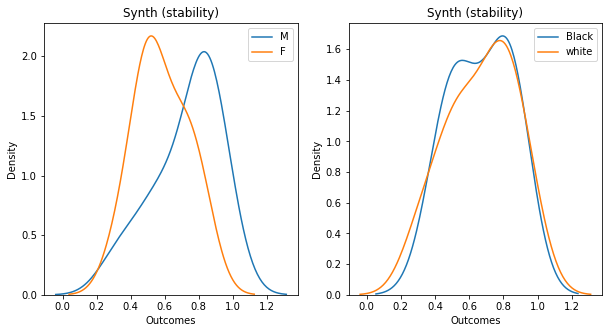

In [256]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(10, 5)
plot_density([df_under.loc[df_under['Sex'] == 1], df_under.loc[df_under['Sex'] == 2]], ['M', 'F'], 'stability', ax[0])
plot_density([df_under.loc[df_under['Race'] == 3], df_under.loc[df_under['Race'] == 4]], ['Black', 'white'], 'stability', ax[1])

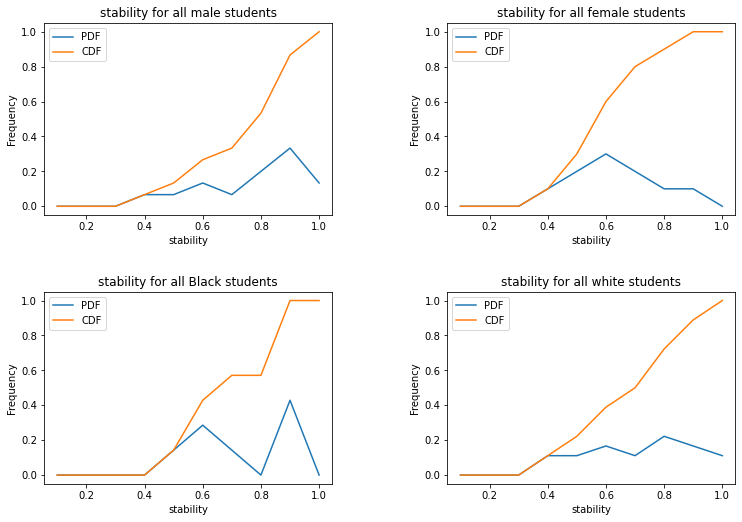

In [254]:
# plot stabilities of each subgroup
plt.figure(figsize=(12, 8))

plot_cdf(df_under.loc[df_under['Sex'] == 1], 'stability', 'all male', 221)
plot_cdf(df_under.loc[df_under['Sex'] == 2], 'stability', 'all female', 222)
plot_cdf(df_under.loc[df_under['Race'] == 3], 'stability', 'all Black', 223)
plot_cdf(df_under.loc[df_under['Race'] == 4], 'stability', 'all white', 224)

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)

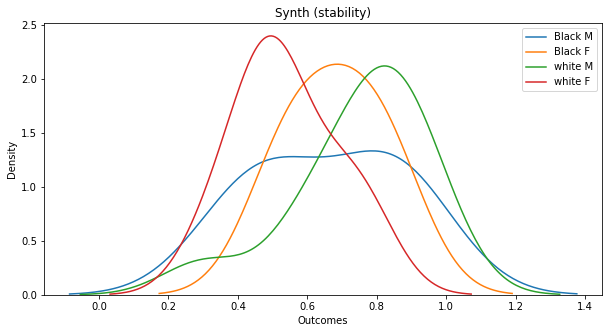

In [258]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 5)
plot_density([df_under.loc[(df_under['Sex'] == 1) & (df_under['Race'] == 3)], 
              df_under.loc[(df_under['Sex'] == 2) & (df_under['Race'] == 3)],
              df_under.loc[(df_under['Sex'] == 1) & (df_under['Race'] == 4)],
              df_under.loc[(df_under['Sex'] == 2) & (df_under['Race'] == 4)]], ['Black M', 'Black F', 'white M', 'white F'], 'stability', ax)

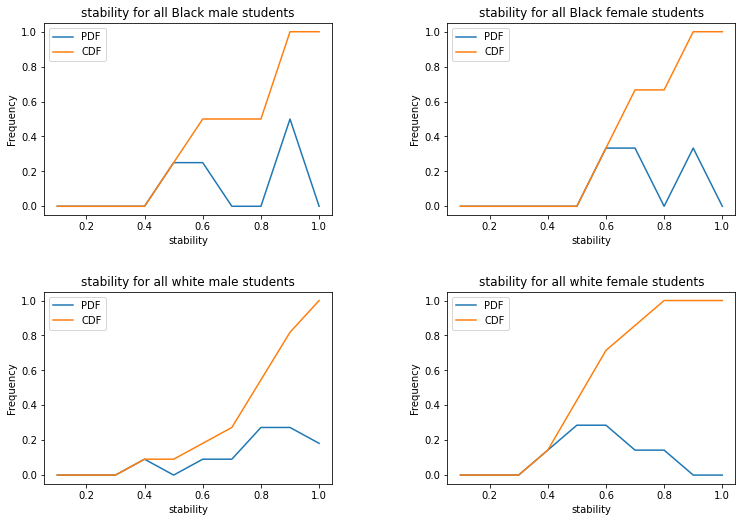

In [259]:
# plot stabilities of each intersectional subgroup
plt.figure(figsize=(12, 8))

plot_cdf(df_under.loc[(df_under['Sex'] == 1) & (df_under['Race'] == 3)], 'stability', 'all Black male', 221) 
plot_cdf(df_under.loc[(df_under['Sex'] == 2) & (df_under['Race'] == 3)], 'stability', 'all Black female', 222)
plot_cdf(df_under.loc[(df_under['Sex'] == 1) & (df_under['Race'] == 4)], 'stability', 'all white male', 223)
plot_cdf(df_under.loc[(df_under['Sex'] == 2) & (df_under['Race'] == 4)], 'stability', 'all white female', 224)

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)